<a href="https://colab.research.google.com/github/PangyourQA/The-Use-of-BiLSTM-and-CNN-LSTM-in-prediction-of-S-P-500-UTM-Master-Thesis-/blob/main/Coding/Mater_Project_2_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import gc
import os
import random
import copy
import matplotlib.pyplot as plt
import pandas
import statsmodels
import math
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Bidirectional, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField

df = yf.download("^GSPC", start="2015-01-01", end="2023-01-01")

[*********************100%***********************]  1 of 1 completed


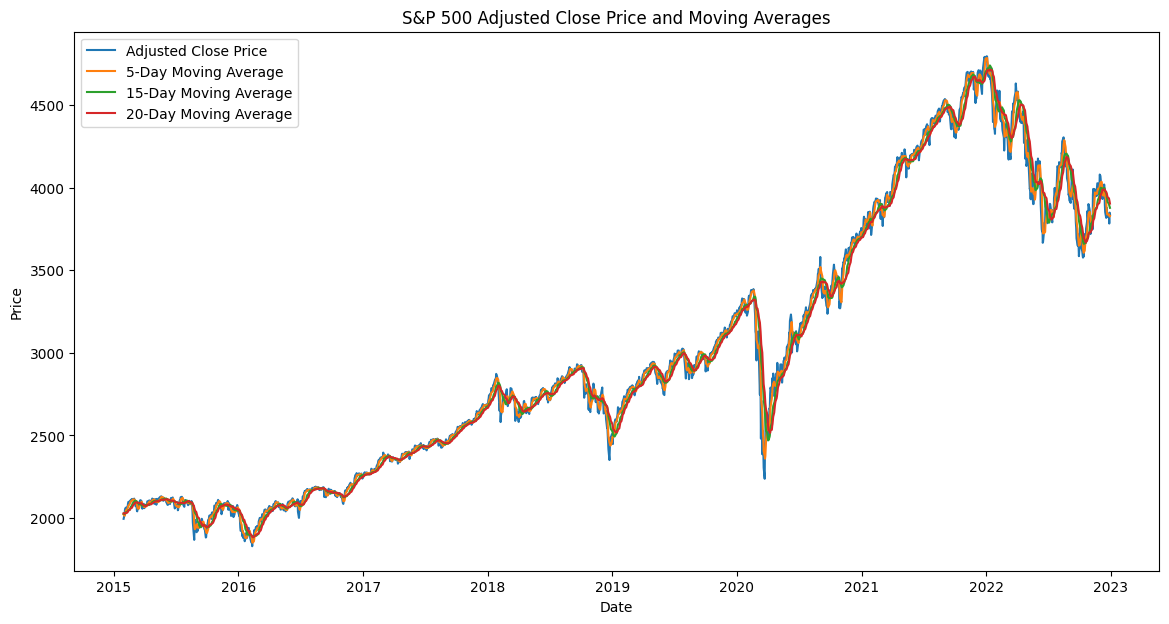

In [ ]:
df_1 = df.iloc[:, 4]
# Calculate the moving averages
df['MA5'] = df['Adj Close'].rolling(window=5).mean()
df['MA15'] = df['Adj Close'].rolling(window=15).mean()
df['MA20'] = df['Adj Close'].rolling(window=20).mean()
# Calculate the moving averages
df_1 = df.drop(['Volume', 'Open', 'High','Low','Close'], axis = 1)
df_1 = df_1.dropna()
df_1.head()

# Plotting the adjusted closing price and the moving averages
plt.figure(figsize=(14, 7))
plt.plot(df_1['Adj Close'], label='Adjusted Close Price')
plt.plot(df_1['MA5'], label='5-Day Moving Average')
plt.plot(df_1['MA15'], label='15-Day Moving Average')
plt.plot(df_1['MA20'], label='20-Day Moving Average')
plt.title('S&P 500 Adjusted Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
df_per = pd.DataFrame((df_1['Adj Close'].pct_change(axis=0)))
df_per = df_per.dropna()
df_per

Ticker,^GSPC
Date,
2015-02-02,0.012962
2015-02-03,0.014439
2015-02-04,-0.004156
2015-02-05,0.010291
2015-02-06,-0.003418
...,...
2022-12-23,0.005868
2022-12-27,-0.004050
2022-12-28,-0.012021


In [ ]:
testing_data_len = math.ceil(len(df_per) * .05)
testing_data_len

100

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_per.values.reshape(-1,1))
scaled_data

array([[0.62153825],
       [0.62845098],
       [0.54142103],
       ...,
       [0.50461354],
       [0.64259363],
       [0.54898089]])

In [ ]:
#test with test dataset
test_data = scaled_data[-(2*testing_data_len):]
X_test = []
# y_test = dataset.iloc[-testing_data_len:, :].values #not scaled data
for i in range(100, len(2*test_data)):
    X_test.append(test_data[i-100:i,0])
# X_test.append(test_data)


In [ ]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 25, 4, 1))

In [ ]:
X_test.shape

(100, 25, 4, 1)

In [ ]:
y_test = df_per.iloc[-testing_data_len:, :]
y_test.shape

(100, 1)

In [ ]:
from tensorflow.keras.models import load_model
model_CNN_Bilstm = load_model('model_CNN_BiLSTM_Return.keras')
model_CNN_LSTM = load_model('model_CNN_LSTM_Return.keras')
model_BiLSTM = load_model('model_BiLSTM_Return.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


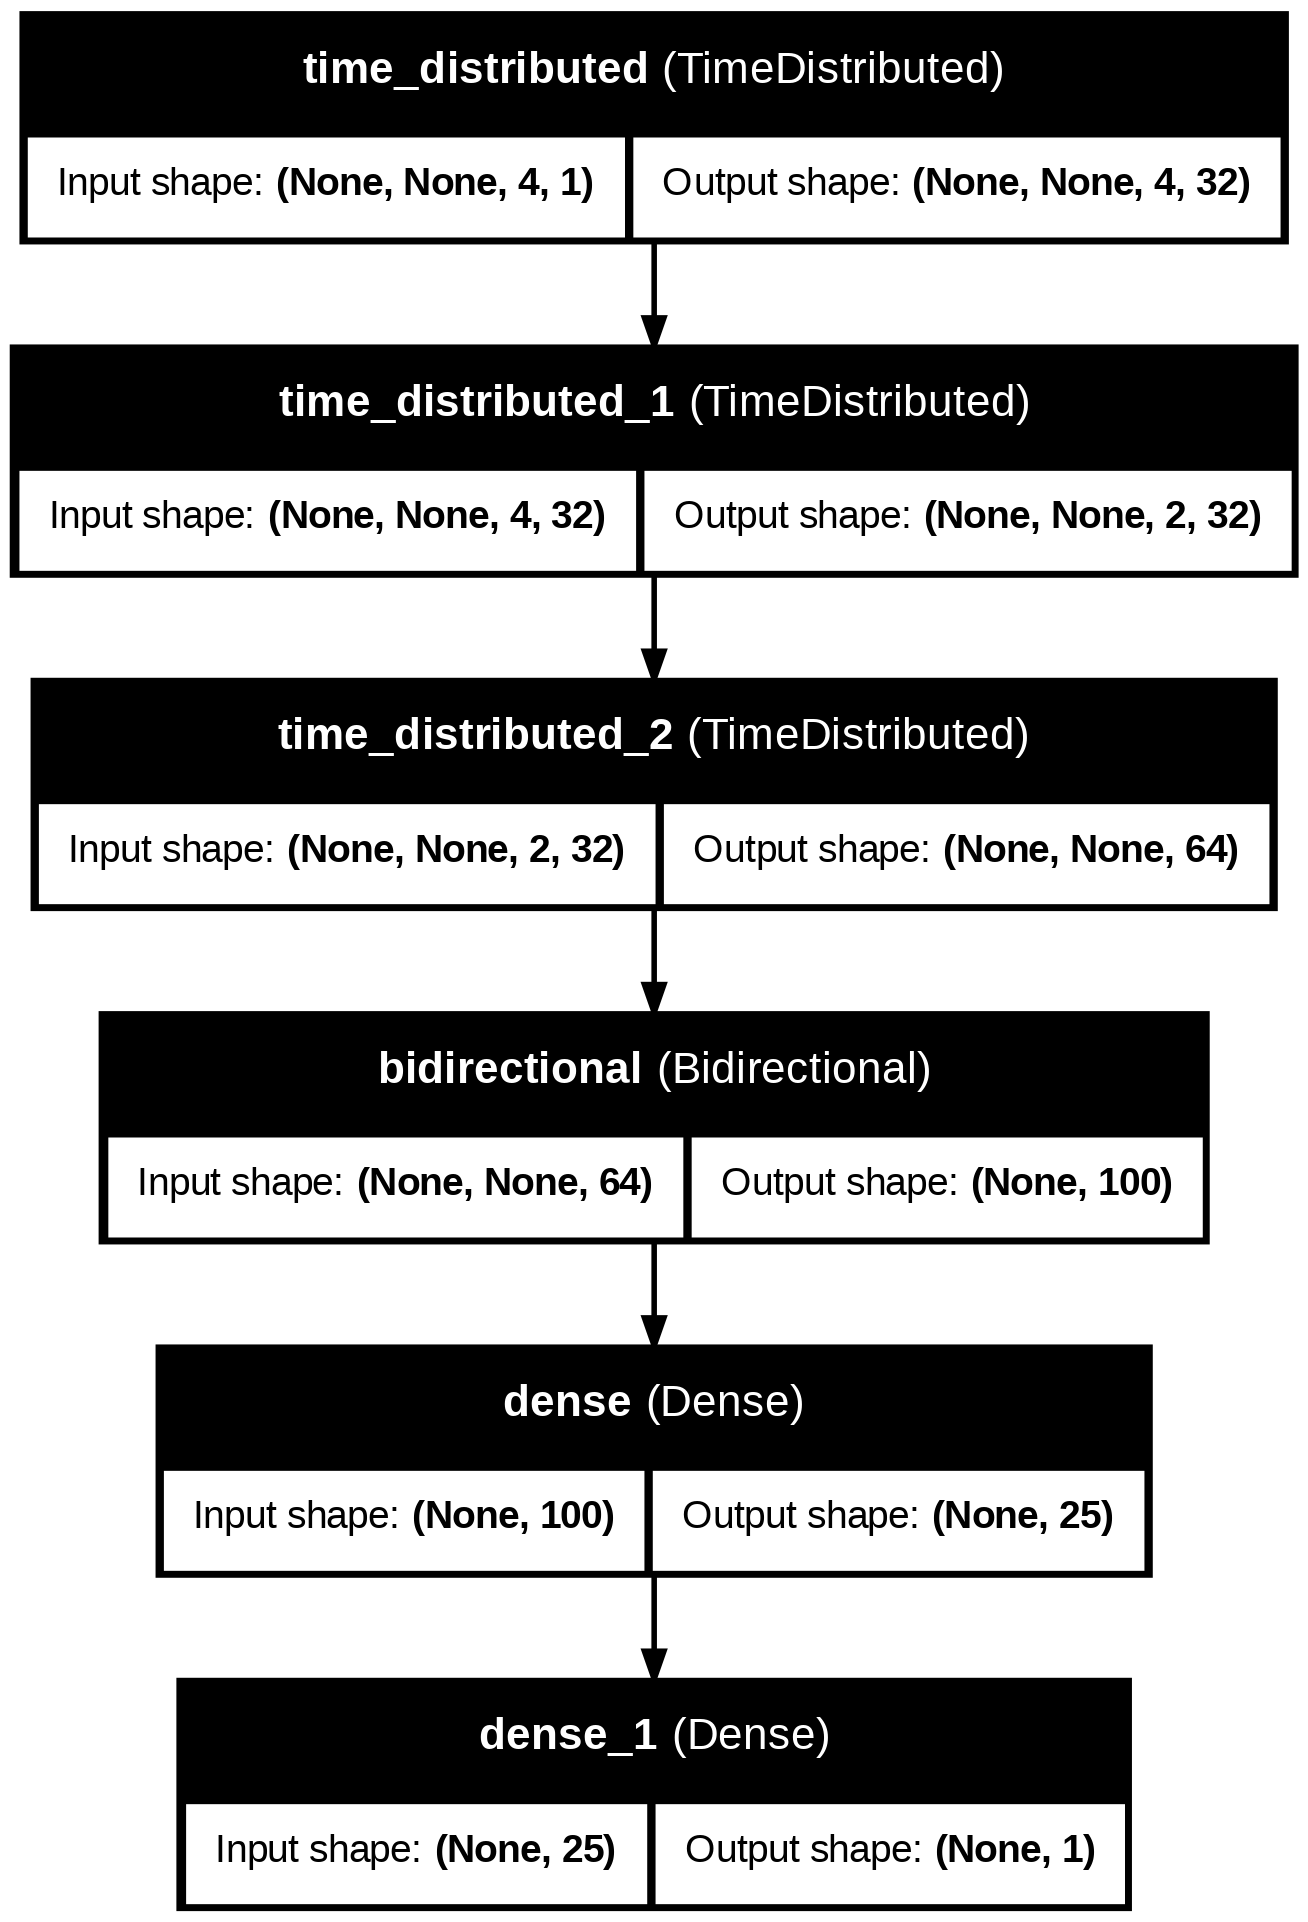

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Generate the plot
plot_model(model_CNN_Bilstm, to_file='model_CNN_Bilstm_structure.png', show_shapes=True, show_layer_names=True)

# Display the plot inline
Image('model_CNN_Bilstm_structure.png')

In [ ]:
for layer in model_CNN_Bilstm.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name}")
    for weight in weights:
        print(weight.shape)  # Shape of each weight matrix or vector

Layer: time_distributed
(1, 1, 32)
(32,)
Layer: time_distributed_1
Layer: time_distributed_2
Layer: bidirectional
(64, 200)
(50, 200)
(200,)
(64, 200)
(50, 200)
(200,)
Layer: dense
(100, 25)
(25,)
Layer: dense_1
(25, 1)
(1,)


In [ ]:
predictions_CNN_BiLSTM = model_CNN_Bilstm.predict(X_test)
predictions_CNN_BiLSTM = scaler.inverse_transform(predictions_CNN_BiLSTM)
predictions_CNN_LSTM = model_CNN_LSTM.predict(X_test)
predictions_CNN_LSTM = scaler.inverse_transform(predictions_CNN_LSTM)
predictions_BiLSTM = model_BiLSTM.predict(X_test)
predictions_BiLSTM = scaler.inverse_transform(predictions_BiLSTM)
predictions_CNN_BiLSTM = np.reshape(predictions_CNN_BiLSTM, (100))
predictions_CNN_LSTM = np.reshape(predictions_CNN_LSTM, (100))
predictions_BiLSTM = np.reshape(predictions_BiLSTM, (100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 768ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step


In [ ]:
values = np.reshape(np.array(y_test),(100))


df_predictions = pd.DataFrame(
    {"Pred CNN-BiLSTM": predictions_CNN_BiLSTM.flatten(), "Pred CNN-LSTM": predictions_CNN_LSTM.flatten(), "Pred BiLSTM": predictions_BiLSTM.flatten(),
     "Return of S&P500": values}, index = df_1[-testing_data_len:].index)
df_predictions.head()

,Pred CNN-BiLSTM,Pred CNN-LSTM,Pred BiLSTM,Return of S&P500
Date,,,,
2022-08-10,0.001798,0.002090,0.002699,0.021291
2022-08-11,0.000762,-0.002724,-0.001228,-0.000705
2022-08-12,0.000471,-0.000629,0.001829,0.017322
2022-08-15,0.000884,-0.002573,-0.005040,0.003970
2022-08-16,0.000933,-0.002689,-0.002173,0.001876


In [ ]:
df_predictions["Positions_1"] = df_predictions["Pred CNN-BiLSTM"].apply(np.sign)
df_predictions["Positions_2"] = df_predictions["Pred CNN-LSTM"].apply(np.sign)
df_predictions["Positions_3"] = df_predictions["Pred BiLSTM"].apply(np.sign)

df_predictions["CNN_BiLSTM_ret"] = (
    df_predictions["Positions_1"] * df_predictions["Return of S&P500"]
)
df_predictions["CNN_LSTM_ret"] = (
    df_predictions["Positions_2"] * df_predictions["Return of S&P500"]
)
df_predictions["BiLSTM_ret"] = (
    df_predictions["Positions_3"] * df_predictions["Return of S&P500"]
)
df_predictions["CNN_BiLSTM_CumRet"] = (
    df_predictions["CNN_BiLSTM_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_predictions["CNN_LSTM_CumRet"] = (
    df_predictions["CNN_LSTM_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_predictions["BiLSTM_CumRet"] = (
    df_predictions["BiLSTM_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)

df_predictions["bhRet"] = df_predictions["Return of S&P500"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_CNN_BiLSTM = np.prod(1 + df_predictions["CNN_BiLSTM_ret"]) - 1
Final_Return_CNN_LSTM = np.prod(1 + df_predictions["CNN_LSTM_ret"]) - 1
Final_Return_BiLSTM = np.prod(1 + df_predictions["BiLSTM_ret"]) - 1
Buy_Return = np.prod(1 + df_predictions["Return of S&P500"]) - 1

print("CNN-BiLSTM Return =", Final_Return_CNN_BiLSTM * 100, "%")
print("CNN-LSTM Return =", Final_Return_CNN_LSTM * 100, "%")
print("BiLSTM Return =", Final_Return_BiLSTM * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")


CNN-BiLSTM Return = 21.272192300181825 %
CNN-LSTM Return = 10.319496565508901 %
BiLSTM Return = 26.8106817885865 %
Buy and Hold Return = -6.864093616125122 %


In [ ]:
excel_file_path = "Return_prediction.xlsx"
df_predictions.to_excel(excel_file_path)

print(f"DataFrame saved as {excel_file_path}")

DataFrame saved as Return_prediction.xlsx


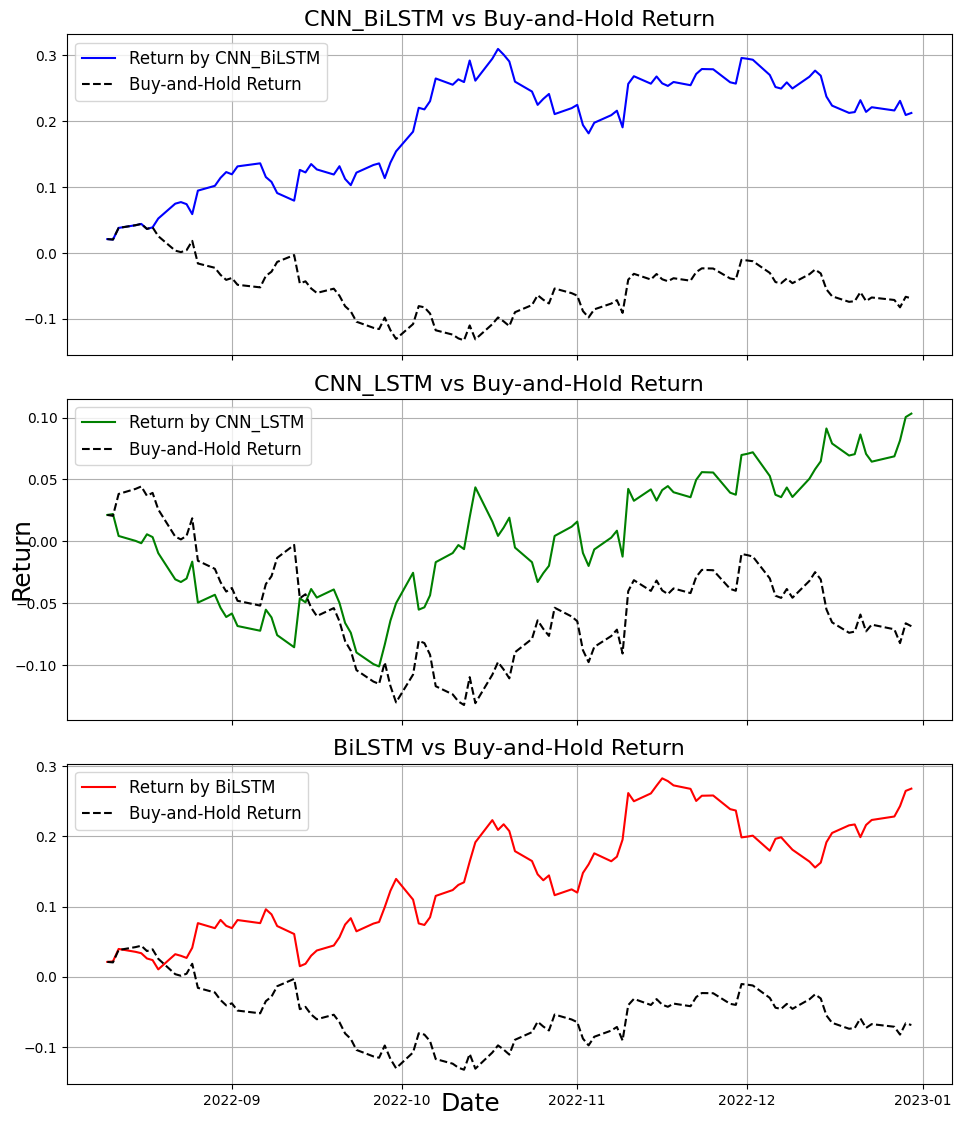

In [ ]:
# Create a figure with 3 subplots (vertically stacked)
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot CNN_BiLSTM_ret vs bhRet
axs[0].plot(df_predictions["CNN_BiLSTM_CumRet"], label='Return by CNN_BiLSTM', color='blue')
axs[0].plot(df_predictions["bhRet"], label='Buy-and-Hold Return', color='black', linestyle='--')
axs[0].set_title('CNN_BiLSTM vs Buy-and-Hold Return', fontsize=16)
axs[0].legend(loc='upper left', fontsize=12)
axs[0].grid(True)

# Plot CNN_LSTM_ret vs bhRet
axs[1].plot(df_predictions["CNN_LSTM_CumRet"], label='Return by CNN_LSTM', color='green')
axs[1].plot(df_predictions["bhRet"], label='Buy-and-Hold Return', color='black', linestyle='--')
axs[1].set_title('CNN_LSTM vs Buy-and-Hold Return', fontsize=16)
axs[1].legend(loc='upper left', fontsize=12)
axs[1].grid(True)

# Plot BiLSTM_ret vs bhRet
axs[2].plot(df_predictions["BiLSTM_CumRet"], label='Return by BiLSTM', color='red')
axs[2].plot(df_predictions["bhRet"], label='Buy-and-Hold Return', color='black', linestyle='--')
axs[2].set_title('BiLSTM vs Buy-and-Hold Return', fontsize=16)
axs[2].legend(loc='upper left', fontsize=12)
axs[2].grid(True)

# Add common labels
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=18)
fig.text(0.04, 0.5, 'Return', va='center', rotation='vertical', fontsize=18)

# Adjust layout
plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
# Save the figure as an image
plt.savefig('returns_comparison.png', dpi=300)
plt.show()

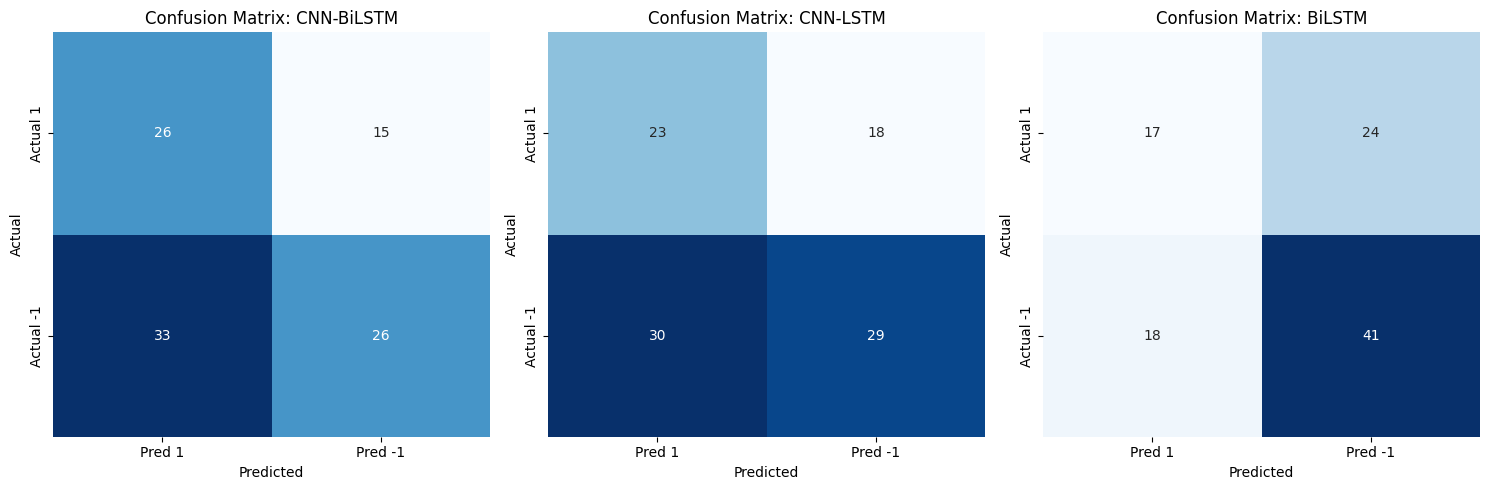

Confusion Matrix: CNN-BiLSTM
[[26 15]
 [33 26]]

Classification Report: CNN-BiLSTM
              precision    recall  f1-score   support

           1       0.44      0.63      0.52        41
          -1       0.63      0.44      0.52        59

    accuracy                           0.52       100
   macro avg       0.54      0.54      0.52       100
weighted avg       0.55      0.52      0.52       100


Confusion Matrix: CNN-LSTM
[[23 18]
 [30 29]]

Classification Report: CNN-LSTM
              precision    recall  f1-score   support

           1       0.43      0.56      0.49        41
          -1       0.62      0.49      0.55        59

    accuracy                           0.52       100
   macro avg       0.53      0.53      0.52       100
weighted avg       0.54      0.52      0.52       100


Confusion Matrix: BiLSTM
[[17 24]
 [18 41]]

Classification Report: BiLSTM
              precision    recall  f1-score   support

           1       0.49      0.41      0.45        4

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Convert actual returns and predicted positions into binary outcomes (1 or -1)
# 1 if return > 0, -1 if return <= 0
actual_labels = np.where(df_predictions["Return of S&P500"] > 0, 1, -1)

# Extract positions based on predictions
predicted_labels_CNN_BiLSTM = df_predictions["Positions_1"].fillna(0).astype(int)
predicted_labels_CNN_LSTM = df_predictions["Positions_2"].fillna(0).astype(int)
predicted_labels_BiLSTM = df_predictions["Positions_3"].fillna(0).astype(int)

# Ensure we align indices for comparison by dropping NaN values introduced by shift
valid_indices = ~df_predictions["Positions_1"].isna()
actual_labels_valid = actual_labels[valid_indices]
predicted_labels_CNN_BiLSTM_valid = predicted_labels_CNN_BiLSTM[valid_indices]
predicted_labels_CNN_LSTM_valid = predicted_labels_CNN_LSTM[valid_indices]
predicted_labels_BiLSTM_valid = predicted_labels_BiLSTM[valid_indices]

# Calculate confusion matrices for each model
conf_matrix_CNN_BiLSTM = confusion_matrix(actual_labels_valid, predicted_labels_CNN_BiLSTM_valid, labels=[1, -1])
conf_matrix_CNN_LSTM = confusion_matrix(actual_labels_valid, predicted_labels_CNN_LSTM_valid, labels=[1, -1])
conf_matrix_BiLSTM = confusion_matrix(actual_labels_valid, predicted_labels_BiLSTM_valid, labels=[1, -1])

# Plot confusion matrices
model_names = ["CNN-BiLSTM", "CNN-LSTM", "BiLSTM"]
conf_matrices = [conf_matrix_CNN_BiLSTM, conf_matrix_CNN_LSTM, conf_matrix_BiLSTM]

plt.figure(figsize=(15, 5))
for i, (name, matrix) in enumerate(zip(model_names, conf_matrices)):
    plt.subplot(1, 3, i + 1)
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Pred 1", "Pred -1"], yticklabels=["Actual 1", "Actual -1"])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# Create classification reports for detailed metrics
report_CNN_BiLSTM = classification_report(actual_labels_valid, predicted_labels_CNN_BiLSTM_valid, labels=[1, -1])
report_CNN_LSTM = classification_report(actual_labels_valid, predicted_labels_CNN_LSTM_valid, labels=[1, -1])
report_BiLSTM = classification_report(actual_labels_valid, predicted_labels_BiLSTM_valid, labels=[1, -1])

# Print results
print("Confusion Matrix: CNN-BiLSTM")
print(conf_matrix_CNN_BiLSTM)
print("\nClassification Report: CNN-BiLSTM")
print(report_CNN_BiLSTM)

print("\nConfusion Matrix: CNN-LSTM")
print(conf_matrix_CNN_LSTM)
print("\nClassification Report: CNN-LSTM")
print(report_CNN_LSTM)

print("\nConfusion Matrix: BiLSTM")
print(conf_matrix_BiLSTM)
print("\nClassification Report: BiLSTM")
print(report_BiLSTM)
